In [65]:
#增加交叉特征
#Score: Score: 0.89048
#使用5折交叉验证,增加scale_pos_weight参数
#Score: Score: 0.89292
#增加G/L
#Score: 0.88696
#交叉特征增加location_type，不使用G/L
#Score: 0.88777
#增加incident_location_type、incident_location_street、policy_bind_date_year&auto_year_diff、incident_date_year&auto_year_diff、duration、出险情况2、出险车信息
#Score: 0.88804
#使用insured_zip，训练使用earlystop，LGBM
#Score: 0.89861
#使用insured_zip, 7折lgbm
#Score: 0.88845
#调整'colsample_bytree': 0.8，7折lgbm
#Score:

In [66]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [67]:
#数据加载
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [68]:
datas = pd.concat((train_data, test_data))
datas.reset_index(drop=True, inplace=True)

## 数据探索

In [69]:
cat_columns = datas.select_dtypes(include=['O']).columns
numerical_columns = datas.select_dtypes(exclude=['O']).columns

In [70]:
col_name = []
unique_value = []
for col in cat_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_cat_col_unique = pd.DataFrame()
df_cat_col_unique['col_name'] = col_name
df_cat_col_unique['unique_value'] = unique_value
df_cat_col_unique = df_cat_col_unique.sort_values('unique_value', ascending= False)
# df_cat_col_unique

In [71]:
col_name = []
unique_value = []
for col in numerical_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_numerical_col_unique = pd.DataFrame()
df_numerical_col_unique['col_name'] = col_name
df_numerical_col_unique['unique_value'] = unique_value
df_numerical_col_unique = df_numerical_col_unique.sort_values('unique_value', ascending= False)
# df_numerical_col_unique

In [72]:
df_cat_col_unique
# df_numerical_col_unique

,col_name,unique_value
15,incident_location,1000
0,policy_bind_date,951
8,incident_date,60
19,auto_model,39
6,insured_hobbies,20
5,insured_occupation,14
18,auto_make,14
4,insured_education_level,7
13,incident_state,7
14,incident_city,7


## 特征工程

#### 标签编码 policy_bind_date、incident_date

In [73]:
datas['policy_bind_date'] = pd.to_datetime(datas['policy_bind_date'])
datas['incident_date'] = pd.to_datetime(datas['incident_date'])

In [74]:
#时间多尺度
datas['policy_bind_date_year'] = datas['policy_bind_date'].dt.year
datas['policy_bind_date_month'] = datas['policy_bind_date'].dt.month
datas['policy_bind_date_day'] = datas['policy_bind_date'].dt.day
datas['policy_bind_date_weekday'] = datas['policy_bind_date'].dt.weekday

datas['incident_date_year'] = datas['incident_date'].dt.year
datas['incident_date_month'] = datas['incident_date'].dt.month
datas['incident_date_day'] = datas['incident_date'].dt.day
datas['incident_date_weekday'] = datas['incident_date'].dt.weekday

In [75]:
# 查看最小、最大日期
# datas.policy_bind_date.min() #1990-01-08
# datas.policy_bind_date.max() #2015-02-22

# datas.incident_date.min() #2015-01-01
# datas.incident_date.max() #2015-03-01

In [76]:
base_date = datas.policy_bind_date.min()
#转换为diff
datas['policy_bind_date_diff'] = (datas['policy_bind_date'] - base_date).dt.days
datas['incident_date_diff'] = (datas['incident_date'] - base_date).dt.days
datas['incident_date&policy_bind_date_diff'] = datas['incident_date_diff'] - datas['policy_bind_date_diff']

#### 构造交叉业务特征

In [77]:
datas['injury_claim_pct'] = datas['injury_claim']/datas['total_claim_amount']
datas['property_claim_pct'] = datas['property_claim']/datas['total_claim_amount']
datas['vehicle_claim_pct'] = datas['vehicle_claim']/datas['total_claim_amount']

In [78]:
datas['is_injury_claim'] = datas['injury_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_property_claim'] = datas['property_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_vehicle_claim'] = datas['vehicle_claim'].apply(lambda x: '1' if x >0 else '0')

In [79]:
#出险情况1
datas['incident_type_&_is_injury_claim'] = datas['incident_type'] + '_' + datas['is_injury_claim']
datas['incident_type_&_is_property_claim'] = datas['incident_type'] + '_' + datas['is_property_claim']
datas['incident_type_&_is_vehicle_claim'] = datas['incident_type'] + '_' + datas['is_vehicle_claim']

datas['collision_type_&_is_injury_claim'] = datas['collision_type'] + '_' + datas['is_injury_claim']
datas['collision_type_&_is_property_claim'] = datas['collision_type'] + '_' + datas['is_property_claim']
datas['collision_type_&_is_vehicle_claim'] = datas['collision_type'] + '_' + datas['is_vehicle_claim']

In [80]:
datas['umbrella_limit_2_total_claim_amount'] = datas['umbrella_limit']/datas['total_claim_amount']

In [81]:
# datas['G/L'] = datas['capital-gains'] + datas['capital-loss']

In [82]:
datas['incident_location_type'] = datas['incident_location'].apply(lambda x: x.split()[-1])
datas['incident_location_street'] = datas['incident_location'].apply(lambda x: ' '.join(x.split()[-2:]))

In [83]:
#购车年份与投保年份之差
datas['policy_bind_date_year&auto_year_diff'] = datas['policy_bind_date_year'] - datas['auto_year']

#购车年份与出险年份之差
datas['incident_date_year&auto_year_diff'] = datas['incident_date_year'] - datas['auto_year']

#成为客户的时长与购报后出险时长之差
datas['duration'] = round((datas['incident_date'] - datas['policy_bind_date']).dt.days/30) - datas['months_as_customer']

In [84]:
#出险情况2
datas['incident_type&collision_type'] = (datas['incident_type'] + "_" + datas['collision_type'])

datas['incident_type&incident_severity'] = (datas['incident_type'] + "_" + datas['incident_severity'])
datas['collision_type&incident_severity'] = (datas['collision_type'] + "_" + datas['incident_severity'])

datas['incident_type&bodily_injuries'] = (datas['incident_type'] + "_" + datas['bodily_injuries'].apply(lambda x : str(x)))
datas['collision_type&bodily_injuries'] = (datas['collision_type'] + "_" + datas['bodily_injuries'].apply(lambda x : str(x)))

datas['incident_type&property_damage'] = (datas['incident_type'] + "_" + datas['property_damage'])
datas['collision_type&property_damage'] = (datas['collision_type'] + "_" + datas['property_damage'])

datas['incident_type&collision_type&incident_severity&bodily_injuries&property_damage'] = (datas['incident_type'] + "_" + datas['collision_type'] + "_" + datas['incident_severity'] 
 + "_" + datas['bodily_injuries'].apply(lambda x : str(x)) + "_" + datas['property_damage'])

In [85]:
#出险车信息
datas['auto_make&auto_model'] = datas['auto_make'] + "_" + datas['auto_model']

In [86]:
# datas[['incident_type', 'collision_type', 'bodily_injuries', 'incident_severity', 'property_damage', 'policy_csl', 'policy_annual_premium', 'umbrella_limit', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'capital-gains', 'capital-loss']][datas['fraud_reported'] > 0]

In [87]:
#检查单个特征
# datas.property_damage.nunique()
# datas['property_damage'].value_counts()

In [88]:
datas.drop(['policy_bind_date', 'incident_date', '_c39', 'incident_location', 'policy_number', 'auto_make', 'auto_model'], axis= 1, inplace=True)
#下次保留insured_zip试试

In [89]:
from sklearn.preprocessing import LabelEncoder

In [90]:
cat_columns = datas.select_dtypes(include= ['O']).columns

In [91]:
for col in cat_columns:
    le = LabelEncoder()
    datas[col] = le.fit_transform(datas[col])

datas[cat_columns]

,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,...,incident_location_street,incident_type&collision_type,incident_type&incident_severity,collision_type&incident_severity,incident_type&bodily_injuries,collision_type&bodily_injuries,incident_type&property_damage,collision_type&property_damage,incident_type&collision_type&incident_severity&bodily_injuries&property_damage,auto_make&auto_model
0,1,2,0,5,10,15,1,2,3,2,...,106,6,7,10,6,9,6,9,170,25
1,0,1,1,3,2,14,2,0,3,1,...,144,2,1,9,2,11,0,9,69,19
2,0,2,0,2,6,16,5,2,3,2,...,78,6,7,10,8,11,6,9,176,21
3,2,2,1,3,13,18,3,0,1,0,...,144,0,0,2,2,5,2,5,8,33
4,2,0,0,4,2,18,3,0,2,2,...,18,1,2,7,2,8,2,8,53,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,0,1,9,11,1,1,0,3,...,125,3,4,1,3,0,4,1,91,12
996,1,1,1,4,0,12,4,0,3,2,...,73,2,2,10,0,9,0,9,72,20
997,1,2,0,0,7,10,1,2,2,1,...,78,5,6,6,6,6,8,8,136,13
998,1,0,0,4,10,10,4,0,3,1,...,100,2,1,9,2,11,2,11,71,25


In [92]:
# 数据集切分
train = datas[datas['fraud_reported'].notnull()]
test = datas[datas['fraud_reported'].isnull()]

In [93]:
train_X = train.drop(['fraud_reported'], axis=1)
train_y = train['fraud_reported']
test_X = test.drop(['fraud_reported'], axis=1)

In [94]:
#增加检验
train_X2,eval_X,train_y2,eval_y = train_test_split(train_X, train_y, test_size=0.2, random_state=2022, stratify=train_y)

## 使用lgbm 训练

In [95]:
import lightgbm as lgb

In [96]:
model_lgb = lgb.LGBMClassifier(
            num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='binary', metric = 'binary_logloss,auc',
            max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2022,
            n_estimators=2000, subsample=1, colsample_bytree=1,
        )

In [97]:
model_lgb.fit(train_X2, train_y2, eval_set=(eval_X, eval_y), #categorical_feature = cat_columns.values.tolist(),
              early_stopping_rounds = 400)

[1]	valid_0's binary_logloss: 0.568025	valid_0's auc: 0.82679
Training until validation scores don't improve for 400 rounds
[2]	valid_0's binary_logloss: 0.566099	valid_0's auc: 0.820646
[3]	valid_0's binary_logloss: 0.564152	valid_0's auc: 0.821181
[4]	valid_0's binary_logloss: 0.562237	valid_0's auc: 0.821181
[5]	valid_0's binary_logloss: 0.560405	valid_0's auc: 0.820913
[6]	valid_0's binary_logloss: 0.558531	valid_0's auc: 0.821181
[7]	valid_0's binary_logloss: 0.55674	valid_0's auc: 0.821181
[8]	valid_0's binary_logloss: 0.555029	valid_0's auc: 0.821181
[9]	valid_0's binary_logloss: 0.553275	valid_0's auc: 0.821181
[10]	valid_0's binary_logloss: 0.551548	valid_0's auc: 0.821181
[11]	valid_0's binary_logloss: 0.549919	valid_0's auc: 0.821715
[12]	valid_0's binary_logloss: 0.548053	valid_0's auc: 0.822382
[13]	valid_0's binary_logloss: 0.546345	valid_0's auc: 0.817708
[14]	valid_0's binary_logloss: 0.544746	valid_0's auc: 0.817842
[15]	valid_0's binary_logloss: 0.543061	valid_0's auc

[173]	valid_0's binary_logloss: 0.422698	valid_0's auc: 0.840678
[174]	valid_0's binary_logloss: 0.422474	valid_0's auc: 0.840678
[175]	valid_0's binary_logloss: 0.422202	valid_0's auc: 0.840678
[176]	valid_0's binary_logloss: 0.421944	valid_0's auc: 0.840946
[177]	valid_0's binary_logloss: 0.421694	valid_0's auc: 0.840946
[178]	valid_0's binary_logloss: 0.421483	valid_0's auc: 0.841213
[179]	valid_0's binary_logloss: 0.421368	valid_0's auc: 0.840946
[180]	valid_0's binary_logloss: 0.420929	valid_0's auc: 0.841213
[181]	valid_0's binary_logloss: 0.420673	valid_0's auc: 0.841213
[182]	valid_0's binary_logloss: 0.420439	valid_0's auc: 0.841213
[183]	valid_0's binary_logloss: 0.420247	valid_0's auc: 0.840678
[184]	valid_0's binary_logloss: 0.420124	valid_0's auc: 0.840678
[185]	valid_0's binary_logloss: 0.41975	valid_0's auc: 0.840678
[186]	valid_0's binary_logloss: 0.419671	valid_0's auc: 0.840411
[187]	valid_0's binary_logloss: 0.419449	valid_0's auc: 0.840411
[188]	valid_0's binary_log

[337]	valid_0's binary_logloss: 0.398455	valid_0's auc: 0.854033
[338]	valid_0's binary_logloss: 0.398405	valid_0's auc: 0.854033
[339]	valid_0's binary_logloss: 0.398359	valid_0's auc: 0.8543
[340]	valid_0's binary_logloss: 0.398567	valid_0's auc: 0.854033
[341]	valid_0's binary_logloss: 0.398554	valid_0's auc: 0.854033
[342]	valid_0's binary_logloss: 0.398628	valid_0's auc: 0.853766
[343]	valid_0's binary_logloss: 0.398639	valid_0's auc: 0.853766
[344]	valid_0's binary_logloss: 0.39863	valid_0's auc: 0.853766
[345]	valid_0's binary_logloss: 0.398835	valid_0's auc: 0.853766
[346]	valid_0's binary_logloss: 0.398826	valid_0's auc: 0.854033
[347]	valid_0's binary_logloss: 0.398707	valid_0's auc: 0.853766
[348]	valid_0's binary_logloss: 0.398924	valid_0's auc: 0.853766
[349]	valid_0's binary_logloss: 0.398913	valid_0's auc: 0.853232
[350]	valid_0's binary_logloss: 0.398839	valid_0's auc: 0.853632
[351]	valid_0's binary_logloss: 0.398893	valid_0's auc: 0.853632
[352]	valid_0's binary_loglo

[527]	valid_0's binary_logloss: 0.404901	valid_0's auc: 0.847489
[528]	valid_0's binary_logloss: 0.4051	valid_0's auc: 0.847222
[529]	valid_0's binary_logloss: 0.405255	valid_0's auc: 0.847222
[530]	valid_0's binary_logloss: 0.405426	valid_0's auc: 0.847222
[531]	valid_0's binary_logloss: 0.405421	valid_0's auc: 0.847222
[532]	valid_0's binary_logloss: 0.405501	valid_0's auc: 0.847222
[533]	valid_0's binary_logloss: 0.40563	valid_0's auc: 0.847222
[534]	valid_0's binary_logloss: 0.405663	valid_0's auc: 0.847222
[535]	valid_0's binary_logloss: 0.405679	valid_0's auc: 0.847489
[536]	valid_0's binary_logloss: 0.405817	valid_0's auc: 0.847756
[537]	valid_0's binary_logloss: 0.405843	valid_0's auc: 0.846955
[538]	valid_0's binary_logloss: 0.406037	valid_0's auc: 0.847489
[539]	valid_0's binary_logloss: 0.406021	valid_0's auc: 0.846688
[540]	valid_0's binary_logloss: 0.40606	valid_0's auc: 0.846955
[541]	valid_0's binary_logloss: 0.406183	valid_0's auc: 0.846421
[542]	valid_0's binary_loglos

[685]	valid_0's binary_logloss: 0.420851	valid_0's auc: 0.840812
[686]	valid_0's binary_logloss: 0.420817	valid_0's auc: 0.840812
[687]	valid_0's binary_logloss: 0.420964	valid_0's auc: 0.840812
[688]	valid_0's binary_logloss: 0.420981	valid_0's auc: 0.841346
[689]	valid_0's binary_logloss: 0.421023	valid_0's auc: 0.841346
[690]	valid_0's binary_logloss: 0.42117	valid_0's auc: 0.841079
[691]	valid_0's binary_logloss: 0.421246	valid_0's auc: 0.840812
[692]	valid_0's binary_logloss: 0.421254	valid_0's auc: 0.840812
[693]	valid_0's binary_logloss: 0.421412	valid_0's auc: 0.840278
[694]	valid_0's binary_logloss: 0.421481	valid_0's auc: 0.840545
[695]	valid_0's binary_logloss: 0.421566	valid_0's auc: 0.840278
[696]	valid_0's binary_logloss: 0.421739	valid_0's auc: 0.840278
[697]	valid_0's binary_logloss: 0.421721	valid_0's auc: 0.840812
[698]	valid_0's binary_logloss: 0.421903	valid_0's auc: 0.840278
[699]	valid_0's binary_logloss: 0.421959	valid_0's auc: 0.840545
[700]	valid_0's binary_log

LGBMClassifier(colsample_bytree=1, learning_rate=0.005,
               metric='binary_logloss,auc', min_child_samples=3,
               n_estimators=2000, objective='binary', random_state=2022,
               reg_alpha=0.25, reg_lambda=0.25, subsample=1)

In [98]:
y_pred = model_lgb.predict_proba(test_X )[:, 1]

#检验
# y_pred = model_lgb.predict_proba(eval_X)[:, 1]

In [99]:
y_pred

array([0.076694  , 0.62414481, 0.05940132, 0.28458207, 0.05824741,
       0.06229193, 0.05974959, 0.07417386, 0.05824741, 0.11337433,
       0.47296365, 0.05856586, 0.65798376, 0.07339302, 0.08313453,
       0.44666857, 0.076694  , 0.07289766, 0.7960574 , 0.06006526,
       0.06510691, 0.13009115, 0.32723912, 0.07517609, 0.07969306,
       0.60573566, 0.06460831, 0.07789666, 0.42057969, 0.07735425,
       0.2735021 , 0.07801074, 0.33771407, 0.05824741, 0.07059037,
       0.06272142, 0.66895853, 0.1170037 , 0.06568188, 0.07152357,
       0.63275007, 0.11888663, 0.11725475, 0.05824741, 0.05849188,
       0.06847311, 0.06807513, 0.06726152, 0.74239121, 0.05824741,
       0.06229193, 0.09833229, 0.05824741, 0.26206246, 0.71330977,
       0.06488225, 0.19080309, 0.26629504, 0.06597529, 0.52833377,
       0.06807513, 0.05824741, 0.05891196, 0.60569024, 0.05824741,
       0.05824741, 0.79145831, 0.54530624, 0.13019329, 0.06229193,
       0.09057221, 0.07662641, 0.36652208, 0.83226663, 0.08828

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

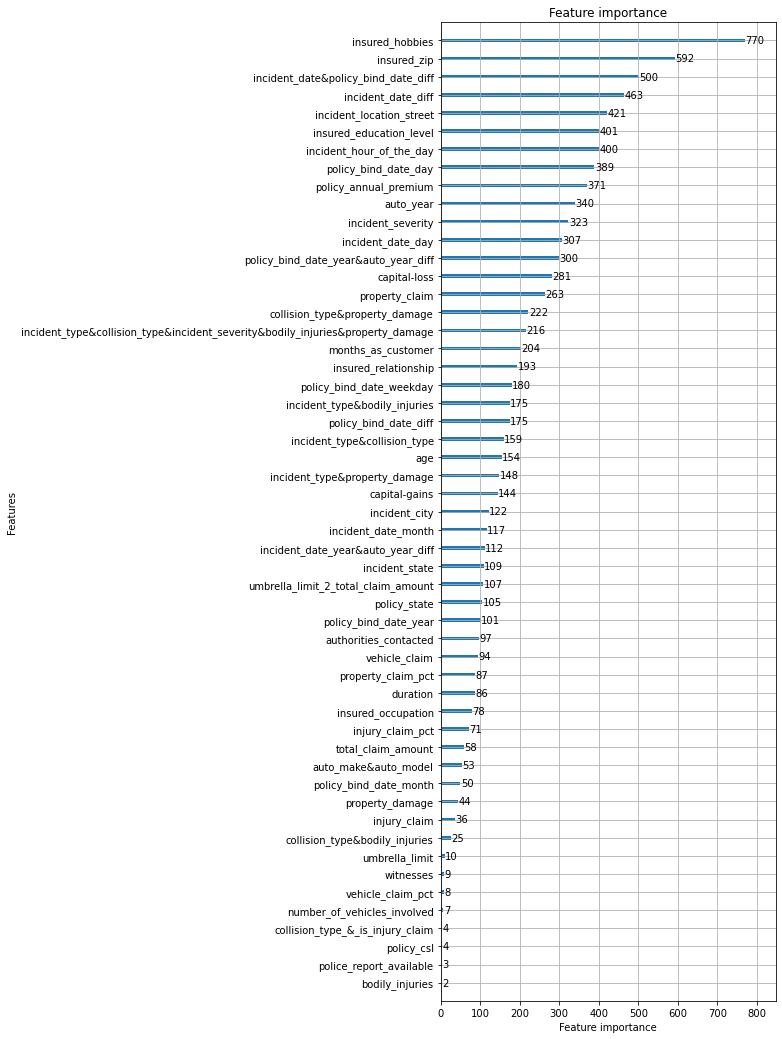

In [100]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(model_lgb, max_num_features=70, ax = ax)

In [101]:
#检验
# roc_auc_score(eval_y, y_pred)

In [102]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission.csv', index=None)

## 使用五折交叉验证的LightGBM

In [103]:
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb

In [104]:
params_lgb = {
    'num_leaves': 2**5-1, 'reg_alpha': 0.25, 'reg_lambda': 0.25, 'objective': 'binary', 'metric': 'binary_logloss,auc',
    'max_depth': -1, 'learning_rate': 0.001, 'min_child_samples': 3, 'random_state': 2022,
    #'n_estimators': 2000, 
    'subsample': 1, 'colsample_bytree': 0.8, #'scale_pos_weight': 3
}

In [105]:
NFOLD = 7

In [106]:
kf = StratifiedKFold(n_splits = NFOLD, shuffle = True, random_state = 2022)

y_pred = np.zeros(len(test_X))

#检验
# y_pred = np.zeros(len(eval_X))

In [107]:
mean_valscore = []
for fold, (train_index, val_index) in enumerate(kf.split(train_X, train_y)):
    X_fold_train, X_fold_val = train_X.iloc[train_index, :], train_X.iloc[val_index, :]
    y_fold_train, y_fold_val = train_y.iloc[train_index], train_y.iloc[val_index]
    train_set = lgb.Dataset(X_fold_train, y_fold_train)
    val_set = lgb.Dataset(X_fold_val, y_fold_val, reference=train_set)

    model_lgb = lgb.train(params_lgb, train_set, num_boost_round=2000, early_stopping_rounds=500,
                      valid_sets = val_set, verbose_eval=100)
    
    mean_valscore.append(model_lgb.best_score['valid_0']['auc'])

    y_pred += model_lgb.predict(test_X)/kf.n_splits
    
print('valscore:', mean_valscore)
print('mean_valscore:', np.mean(mean_valscore))
    
    #检验
#     y_pred += model_lgb.predict(eval_X, num_iteration=model_lgb.best_iteration)/kf.n_splits

# y_pred = [1 if y > 0.5 else 0 for y in y_pred]
# rmse = metrics.accuracy_score(y_pred,y_test)
# print(rmse)

[LightGBM] [Info] Number of positive: 156, number of negative: 444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3135
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260000 -> initscore=-1.045969
[LightGBM] [Info] Start training from score -1.045969
Training until validation scores don't improve for 500 rounds
[100]	valid_0's binary_logloss: 0.535644	valid_0's auc: 0.8224
[200]	valid_0's binary_logloss: 0.513509	valid_0's auc: 0.821333
[300]	valid_0's binary_logloss: 0.496093	valid_0's auc: 0.830933
[400]	valid_0's binary_logloss: 0.481385	valid_0's auc: 0.830933
[500]	valid_0's binary_logloss: 0.468649	valid_0's auc: 0.829867
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.558296	valid_0's auc: 0.852267
[LightGBM] [Info] Number 

In [108]:
#检验
# roc_auc_score(eval_y, y_pred)

In [109]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission_Kfold.csv', index=None)